To perform statistical entropy analysis in Python for EEG data, you can use libraries such as nolds or pyEEG. These libraries provide functions to calculate different types of entropy measures, including approximate entropy (ApEn), sample entropy (SampEn), and permutation entropy (PermEn)

Shannon Entropy: Shannon entropy is a widely used measure of uncertainty or information content in a signal. It quantifies the amount of information or randomness present in the signal. It can be useful for analyzing the overall complexity of EEG signals.

Approximate Entropy (ApEn): Approximate entropy is a measure of regularity or complexity in time series data. It quantifies the likelihood that similar patterns repeat in the signal. ApEn can be helpful in assessing the complexity of EEG signals and detecting changes in regularity.

Sample Entropy (SampEn): Sample entropy is a variation of approximate entropy that addresses some limitations of ApEn. It measures the likelihood of similar patterns repeating in a signal while also taking into account self-matches of shorter patterns. SampEn can provide insights into the complexity and irregularity of EEG signals.

Renyi Entropy: Renyi entropy is a generalization of Shannon entropy that includes a parameter to control the level of sensitivity to different probability distributions. It provides a measure of the diversity or variability in the signal.

Permutation Entropy: Permutation entropy measures the amount of disorder or randomness in the order of patterns in a signal. It considers the relative order of values rather than their actual magnitudes. Permutation entropy can be useful in characterizing the complexity and irregularity of EEG signals.

-----------
Shannon and Sample Entropies
----------

In [51]:
#---------SHANNON ENTROPY

import numpy as np
from scipy.stats import entropy
import mne, os
import  nolds# pyeeg,
from mne import Epochs
from nolds import sampen
from pyentrp import entropy as py_entropy
import mne

mne.set_log_level("ERROR")
raw_folder = os.path.join(os.path.expanduser('~/'),'Desktop', 'FYP', 'code_env', 'eeg-notebooks','FYP', 'data_ordered', 'mne_raw')
raw_files = [file for file in os.listdir(raw_folder) if file.endswith(".fif")]
marker_mapping = {"blue": 1, "red": 2, "right": 3, "left": 4, "right arrow": 5, "left arrow": 6}
duration = 30.0  # Duration of each epoch (seconds)
event_ids = {'left': 4, 'right': 3}  # Replace with your event IDs
tmin, tmax = -0.3, 0.7
evokeds_left = {}
evokeds_right = {}

entropy_audio = []
entropy_shape = []
entropy_vibro = []

# Process each raw file and extract evoked response
for file in raw_files:
    high_entropy = False
    print("Computing entropy for trial",file)
    raw_path = os.path.join(raw_folder, file)
    raw = mne.io.read_raw_fif(raw_path, preload=True)
    data = raw.get_data()
    events, event_id= mne.events_from_annotations(raw, event_id=marker_mapping)
    epochs = Epochs(raw, events=events, event_id=event_ids, tmin=-0.3, tmax=0.7, baseline=None, preload=True)
    m = 2  # embedding dimension
    r = 0.2 * np.std(raw.get_data())  # tolerance threshold
    # Compute entropy for each channel
    entropy_values = []
    #for channel_data in data:
    for ch_name in event_ids.keys():
        #channel_entropy = entropy(np.abs(channel_data))
        #channel_entropy = pyeeg.ap_entropy
        channel_data = epochs[ch_name].get_data().reshape(-1)
        channel_entropy = sampen(channel_data, m, r)
        #py_entropy.permutation_entropy(channel_data, 3, 1)
        #channel_entropy = entropy(channel_data, emb_dim=10, r=0.1)
        
        entropy_values.append(channel_entropy)

    # Print the entropy values for each channel
    for channel_idx, entropy_value in enumerate(entropy_values):
        print(f'Channel {channel_idx + 1}: {entropy_value}')
        #if entropy_value > 12:
        #    high_entropy = True
            
    if not high_entropy:
        if not np.any(np.isnan(entropy_values)):
            if "Shape" in file:
                entropy_shape.append(entropy_values)   
            elif "Audio" in file:
                entropy_audio.append(entropy_values) 
            elif "Vibro" in file:
                entropy_vibro.append(entropy_values) 


Computing entropy for trial AudioVisual_01_1.fif


KeyboardInterrupt: 

(38,)
Variables saved to JSON file: entropy.json
Audio 0.4160164714421939 0.2062588119654706
Vibro 0.4479658881829459 0.25894855837703945
Shape 0.4165355187796874 0.2054169213161596


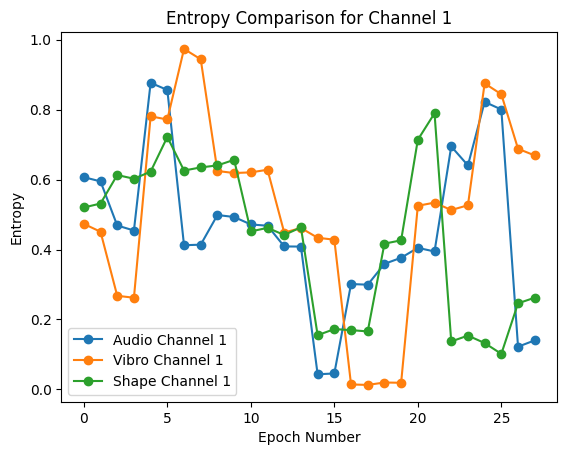

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import json

entropy_audio = np.array(entropy_audio)
audio_entropy_mean = np.mean(entropy_audio)
audio_entropy_std = np.std(entropy_audio)
print(entropy_audio.shape)
entropy_vibro = np.array(entropy_vibro)
vibro_entropy_mean = np.mean(entropy_vibro)
vibro_entropy_std = np.std(entropy_vibro)
#print(entropy_vibro)
entropy_shape = np.array(entropy_shape)
shape_entropy_mean = np.mean(entropy_shape)
shape_entropy_std = np.std(entropy_shape)
entropy_audio = entropy_audio[np.isfinite(entropy_audio)]
entropy_vibro = entropy_vibro[np.isfinite(entropy_vibro)]
entropy_shape = entropy_shape[np.isfinite(entropy_shape)]
#print(entropy_shape)
json_file_path = 'entropy.json'
entropy = {"Audio": entropy_audio.tolist(), "Vibro": entropy_vibro.tolist(), "Shape": entropy_shape.tolist()}
#entropy = (np.array(entropy))
# Save the variables to a JSON file
with open(json_file_path, 'w') as file:
    json.dump(entropy, file, indent=4)
print("Variables saved to JSON file:", json_file_path)

print("Audio", audio_entropy_mean, audio_entropy_std)
print("Vibro", vibro_entropy_mean, vibro_entropy_std)
print("Shape", shape_entropy_mean, shape_entropy_std)

#num_channels = entropy_audio.shape[1]

# Generate x-axis values (assuming equal length arrays)
x = np.arange(28)

# Plotting for each channel
#for channel in range(1):
channel = 0
plt.plot(x, entropy_audio[:28], label=f'Audio Channel {channel+1}', marker='o')
plt.plot(x, entropy_vibro[:28], label=f'Vibro Channel {channel+1}', marker='o')
plt.plot(x, entropy_shape[:28], label=f'Shape Channel {channel+1}', marker='o')

# Add labels, title, and legend for each plot
plt.xlabel('Epoch Number')
plt.ylabel('Entropy')
plt.title(f'Entropy Comparison for Channel {channel+1}')
plt.legend()

# Show the plot
plt.show()

-------
Statistical Analysis SE
--------

In [29]:
import scipy.stats as stats
from scipy.stats import f_oneway
# Perform the Brown-Forsythe test
num_channels = entropy_audio.shape[1]

# Generate x-axis values (assuming equal length arrays)
x = np.arange(14)

# Plotting for each channel
for channel in range(num_channels):
    _, p_value = stats.levene(entropy_audio[:14,channel], entropy_vibro[:14,channel], entropy_shape[:14,channel], center='median')

    # Print the results
    if p_value < 0.05:
        print("The variances are significantly different (p < 0.05), violating the assumption of homogeneous variance.")
    else:
        print("The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance.", p_value)

    f_value, p_value = f_oneway(entropy_audio[:14,channel], entropy_vibro[:14,channel], entropy_shape[:14,channel])

    print(f"ANOVA results for {channel}")
    print("p-values:", p_value )


The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance. 0.39967325528090336
ANOVA results for 0
p-values: 0.7443996779485846
The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance. 0.7079712934287015
ANOVA results for 1
p-values: 0.8267353497645535
The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance. 0.8078289409109112
ANOVA results for 2
p-values: 0.7436127906563645
The variances are not significantly different (p >= 0.05), supporting the assumption of homogeneous variance. 0.5148837162249431
ANOVA results for 3
p-values: 0.16797344719722238


-------------
Approximate Entropy ApEn
--------------

In [ ]:
#------------approximate Entropy ApEn

import numpy as np
import pyeeg

# Load the EEG data as a NumPy array
data = np.loadtxt('eeg_data.txt')

# Compute approximate entropy for each channel
entropy_values = []
for channel_data in data:
    entropy_value = pyeeg.ap_entropy(channel_data)
    entropy_values.append(entropy_value)

# Print the entropy values for each channel
for channel_idx, entropy_value in enumerate(entropy_values):
    print(f'Channel {channel_idx + 1}: {entropy_value}')


In [ ]:
import numpy as np
from nolds import entropy
import mne

# Load the EEG data using MNE Raw object
raw = mne.io.read_raw_edf('your_eeg_file.edf', preload=True)

# Extract the data as a NumPy array
data = raw.get_data()

# Compute statistical entropy for each channel
entropy_values = []
for channel_data in data:
    entropy_value = entropy(channel_data, emb_dim=10, r=0.1)
    entropy_values.append(entropy_value)

# Print the entropy values for each channel
for channel_idx, entropy_value in enumerate(entropy_values):
    print(f'Channel {channel_idx + 1}: {entropy_value}')
